<a href="https://colab.research.google.com/github/ysj9909/Contrastive_Stock_price_Matching/blob/main/Contrastive_Stock_Tendency_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install timm

# 모듈 불러오기

In [2]:
import math
import time
import copy
import csv
from PIL import Image
import os
import os.path
import numpy as np
from numpy import *
import torch
import torch.nn as  nn
import torch.nn.functional as F
import pandas as pd
from pandas import read_csv
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torchvision.transforms as transforms
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

In [3]:
# device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터셋 준비

* 데이터 로드 및 결측치 제거

In [4]:
df = read_csv('stockdata720.csv')
df = df.transpose()
df = df.dropna()
data = np.array(df.values)
data.shape

(11580, 259)

* train / test split

In [5]:
data_test = [data[11180]]
for i in range(1,100):
  data_test = np.append(data_test, [data[11180+ 4*i]], axis = 0)

data = data[:11180]

data_test

array([[21670., 21745., 21810., ..., 20325., 20705., 20620.],
       [15475., 15635., 15610., ..., 17370., 17655., 17620.],
       [61335., 58595., 58225., ..., 41125., 41450., 41055.],
       ...,
       [13600., 13800., 14150., ...,  6840.,  6770.,  6590.],
       [32100., 31900., 31450., ..., 12850., 12650., 12300.],
       [11350., 11350., 11750., ...,  5070.,  5300.,  5240.]])

* test dataset normalization

In [6]:
data_test = data_test[:,0:60]
data_test_norm = np.array(data_test)
for i in range(100):
  data_test_norm[i] = ((data_test[i]-np.mean(data_test[i],axis=0))/(np.std(data_test[i],axis=0)) + 1e-10)

data_test_norm = torch.from_numpy(data_test_norm).to(device)
data_test = torch.from_numpy(data_test)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [239]:
print(data_test.shape)

torch.Size([100, 259])


* data augmentation (flip)

In [7]:
data = np.append(data, np.fliplr(data), axis=0)

data.shape

(22360, 259)

* 종가 데이터

In [8]:
data_close=[data[0]]
for i in range(1,5590):
  arr = np.array(data[4*i])
  data_close = np.append(data_close, [arr], axis=0)

"""
data_close_norm=[data_norm[0]]
for i in range(1,5590):
  arr = np.array(data_norm[4*i])
  data_close_norm = np.append(data_close_norm, [arr], axis=0)
"""
data_close.shape

(5590, 259)

* 시가 데이터

In [9]:
data_open=[data[1]]
for i in range(1,5590):
  arr = np.array(data[4*i+1])
  data_open = np.append(data_open, [arr], axis=0)
"""
data_open_norm=[data_norm[1]]
for i in range(1,5590):
  arr = np.array(data_norm[4*i+1])
  data_open_norm = np.append(data_open_norm, [arr], axis=0)
"""

data_open

array([[  1240.,   1235.,   1220., ...,    800.,    775.,    737.],
       [ 15700.,  15900.,  15850., ...,  11000.,  11100.,  11050.],
       [112000., 113500., 113500., ...,  73300.,  72800.,  71200.],
       ...,
       [ 16575.,  16565.,  16615., ...,  19025.,  19070.,  19520.],
       [ 17985.,  18070.,  17705., ...,  22175.,  22000.,  22000.],
       [ 15430.,  15460.,  15135., ...,  15865.,  15935.,  15805.]])

* 고가 데이터

In [10]:
data_high=[data[2]]
for i in range(1,5590):
  arr = np.array(data[4*i+2])
  data_high = np.append(data_high, [arr], axis=0)
"""
data_high_norm=[data_norm[2]]
for i in range(1,5590):
  arr = np.array(data_norm[4*i+2])
  data_high_norm = np.append(data_high_norm, [arr], axis=0)
"""

data_high

array([[  1250.,   1235.,   1225., ...,    832.,    775.,    789.],
       [ 15900.,  15950.,  16350., ...,  11150.,  11300.,  11300.],
       [115000., 114500., 114000., ...,  73300.,  73200.,  73500.],
       ...,
       [ 16575.,  16615.,  16615., ...,  19025.,  19070.,  19520.],
       [ 17985.,  18105.,  17705., ...,  22175.,  22000.,  22035.],
       [ 15430.,  15460.,  15135., ...,  15865.,  15935.,  15805.]])

* 저가 데이터

In [11]:
data_low=[data[3]]
for i in range(1,5590):
  arr = np.array(data[4*i+3])
  data_low = np.append(data_low, [arr], axis=0)

"""
data_low_norm=[data_norm[3]]
for i in range(1,5590):
  arr = np.array(data_norm[4*i+3])
  data_low_norm = np.append(data_low_norm, [arr], axis=0)
"""

data_low.shape

(5590, 259)

In [12]:
data_close60 = data_close[:,:60]
data_open60 = data_open[:,:60]
data_high60 = data_high[:,:60]
data_low60 = data_low[:,:60]

for i in range(1,11):
  data_close60 = np.append(data_close60, data_close[:, 20*i-1:20*i+60-1], axis=0)

for i in range(1,11):
  data_open60 = np.append(data_open60, data_open[:,20*i-1:20*i+60-1], axis=0)

for i in range(1,11):
  data_high60 = np.append(data_high60, data_high[:,20*i-1:20*i+60-1], axis=0)

for i in range(1,11):
  data_low60 = np.append(data_low60, data_low[:,20*i-1:20*i+60-1], axis=0)

data_low60.shape

(61490, 60)

* normalization

In [13]:
data_close60_norm =  (data_close60 - np.mean(data_close60, axis = -1, keepdims = True)) / (np.std(data_close60, axis = -1, keepdims = True) + 1e-10)
data_open60_norm =  (data_open60 - np.mean(data_open60, axis = -1, keepdims = True)) / (np.std(data_open60, axis = -1, keepdims = True) + 1e-10)
data_high60_norm =  (data_high60 - np.mean(data_high60, axis = -1, keepdims = True)) / (np.std(data_high60, axis = -1, keepdims = True) + 1e-10)
data_low60_norm =  (data_low60 - np.mean(data_low60, axis = -1, keepdims = True)) / (np.std(data_low60, axis = -1, keepdims = True) + 1e-10)


print(data_open60_norm)

[[ 0.84226025  0.77620062  0.57802174 ... -1.60194597 -1.60194597
  -1.60194597]
 [ 0.76023455  1.05934323  0.98456606 ...  3.07832679  3.67654414
   3.67654414]
 [-0.01967229  0.16669677  0.16669677 ...  1.09854207  0.66368093
   0.47731187]
 ...
 [-0.2231395  -0.20455315 -0.92942093 ...  1.48680502  1.54256408
   2.10015469]
 [ 0.77964291  1.17335097  1.19152211 ... -1.36455175 -1.5765484
  -1.5765484 ]
 [ 1.47389637  0.0264069  -0.09095711 ...  1.10224367  1.37609303
   0.86751565]]


In [14]:
data_close120 = data_close[:,:120]
data_open120 = data_open[:,:120]
data_high120 = data_high[:,:120]
data_low120 = data_low[:,:120]

for i in range(1,8):
  data_close120 = np.append(data_close120, data_close[:,20*i-1:20*i+120-1], axis=0)

for i in range(1,8):
  data_open120 = np.append(data_open120, data_open[:,20*i-1:20*i+120-1], axis=0)

for i in range(1,8):
  data_high120 = np.append(data_high120, data_high[:,20*i-1:20*i+120-1], axis=0)

for i in range(1,8):
  data_low120 = np.append(data_low120, data_low[:,20*i-1:20*i+120-1], axis=0)

data_close120.shape

(44720, 120)

* normalization

In [15]:
data_close120_norm =  (data_close120 - np.mean(data_close120, axis = -1, keepdims = True)) / (np.std(data_close120, axis = -1, keepdims = True) + 1e-10)
data_open120_norm =  (data_open120 - np.mean(data_open120, axis = -1, keepdims = True)) / (np.std(data_open120, axis = -1, keepdims = True) + 1e-10)
data_high120_norm =  (data_high120 - np.mean(data_high120, axis = -1, keepdims = True)) / (np.std(data_high120, axis = -1, keepdims = True) + 1e-10)
data_low120_norm =  (data_low120 - np.mean(data_low120, axis = -1, keepdims = True)) / (np.std(data_low120, axis = -1, keepdims = True) + 1e-10)

print(data_close120_norm)

[[ 1.35473519  1.19927165  1.16040577 ... -1.42806216 -1.52134029
  -1.56020617]
 [ 0.26826051  0.23113103  0.41677844 ... -0.771365   -0.40007017
  -0.58571759]
 [ 0.75863283  0.69549235  0.25350902 ... -1.11032529 -1.13558148
  -1.17346577]
 ...
 [ 0.49282025  0.22798538  0.21996008 ...  1.76081753  1.85712113
   2.60347396]
 [ 0.57572554  0.39651677 -0.00774488 ... -1.55394147 -1.69980907
  -1.67063555]
 [ 0.68561717  0.35184816 -0.14880535 ... -0.12655408 -0.12655408
  -0.26006168]]


In [16]:
data_close60 = torch.from_numpy(data_close60)

data_open60 = torch.from_numpy(data_open60)

data_high60 = torch.from_numpy(data_high60)

data_low60 = torch.from_numpy(data_low60)

data_close60_norm = torch.from_numpy(data_close60_norm)

data_open60_norm = torch.from_numpy(data_open60_norm)

data_high60_norm = torch.from_numpy(data_high60_norm)

data_low60_norm = torch.from_numpy(data_low60_norm)

data_close120 = torch.from_numpy(data_close120)

data_open120 = torch.from_numpy(data_open120)

data_high120 = torch.from_numpy(data_high120)

data_low120 = torch.from_numpy(data_low120)

data_close120_norm = torch.from_numpy(data_close120_norm)

data_open120_norm = torch.from_numpy(data_open120_norm)

data_high120_norm = torch.from_numpy(data_high120_norm)

data_low120_norm = torch.from_numpy(data_low120_norm)

In [17]:
print(data_close60_norm.shape)

torch.Size([61490, 60])


In [18]:
train_X_60 = torch.cat([data_close60_norm, data_close60_norm, data_close60_norm, 
                     data_open60_norm, data_open60_norm], dim = 0)
train_Y_60 = torch.cat([data_open60, data_high60, data_low60, data_high60,
                     data_low60], dim = 0)
train_Y_norm_60 = torch.cat([data_open60_norm, data_high60_norm, data_low60_norm, 
                          data_high60_norm, data_low60_norm], dim = 0)

train_X_120 = torch.cat([data_close120_norm, data_close120_norm, data_close120_norm, 
                     data_open120_norm, data_open120_norm], dim = 0)
train_Y_120 = torch.cat([data_open120, data_high120, data_low120, data_high120,
                     data_low120], dim = 0)
train_Y_norm_120 = torch.cat([data_open120_norm, data_high120_norm, data_low120_norm, 
                          data_high120_norm, data_low120_norm], dim = 0)

In [19]:
class MyBaseDataset(Dataset):
    def __init__(self, x_data, y_data, y_norm_data):
        self.x_data = x_data
        self.y_data = y_data
        self.y_norm_data = y_norm_data
        
    def __getitem__(self, index): 
        return self.x_data[index], self.y_data[index], self.y_norm_data[index]
        
    def __len__(self): 
        return self.x_data.shape[0]

In [20]:
train_data_60 = TensorDataset(train_X_60,train_Y_60, train_Y_norm_60)
val_data_60 = TensorDataset(data_high60, data_high60_norm,data_low60, data_low60_norm)

train_data_120 = TensorDataset(train_X_120,train_Y_120, train_Y_norm_120)
val_data_120 = TensorDataset(data_high120, data_high120_norm,data_low120, data_low120_norm)

In [90]:
BATCH_SIZE = 512


train_loader_60 = DataLoader(train_data_60, batch_size = BATCH_SIZE, shuffle = True)
val_loader_60 = DataLoader(val_data_60, batch_size = 16, shuffle = True)

train_loader_120 = DataLoader(train_data_120, batch_size = BATCH_SIZE, shuffle = True)
val_loader_120 = DataLoader(val_data_120, batch_size = BATCH_SIZE, shuffle = True)

# 모델 정의

In [22]:
class ConvEmbedding(nn.Module):
    def __init__(self, 
                 patch_size = 5,
                 stride = 1,
                 in_chans = 1,
                 embed_dim = 64):
        super().__init__()

        self.conv = nn.Conv1d(in_chans, embed_dim,
                              kernel_size = patch_size, 
                              stride = stride, padding = patch_size // 2)
        
        self.norm = nn.LayerNorm(embed_dim)
    
    def forward(self, x):
        # x, shape of (Batch_size, in_channels, seq_length)
        x = self.conv(x)
        x = x.transpose(-2, -1)
        x = self.norm(x)

        return x

In [23]:
class Attention(nn.Module):
    def __init__(self, 
                 dim,
                 num_heads = 8,
                 qkv_bias = False,
                 qk_scale = None,
                 attn_drop = 0.,
                 proj_drop = 0.,):
        super().__init__()

        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or  head_dim ** -.5

        self.qkv = nn.Linear(dim, dim * 3, bias = qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape

        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim = -1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, -1)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [24]:
class Mlp(nn.Module):
    def __init__(self, 
                 in_features,
                 hidden_features = None,
                 out_features = None,
                 act_layer = nn.ReLU,
                 drop = 0.):
        super().__init__()

        out_features = out_features or in_features
        hidden_features = hidden_features or in_features

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [25]:
class Block(nn.Module):
    def __init__(self, 
                 dim,
                 num_heads,
                 mlp_ratio = 4.,
                 qkv_bias = False,
                 drop = 0.,
                 drop_path = 0.,
                 attn_drop = 0.,
                 act_layer = nn.ReLU,
                 norm_layer = nn.LayerNorm,
                 ):
        super().__init__()

        self.norm1 = norm_layer(dim)
        self.MSA = Attention(dim, num_heads, qkv_bias, attn_drop = attn_drop, proj_drop = drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0 else nn.Identity()

        self.norm2 = norm_layer(dim)
        self.FFN = Mlp(dim, int(mlp_ratio * dim), act_layer = act_layer, drop = drop)

    def forward(self, x):
        x = x + self.drop_path(self.MSA(self.norm1(x)))
        x = x + self.drop_path(self.FFN(self.norm2(x)))

        return x

In [68]:
class Time_Series_Encoder(nn.Module):
    def __init__(self,
                 patch_size = 5,
                 in_chans = 1,
                 embed_dims = [64, 128, 256],
                 strides = [1, 2, 2],
                 num_heads = [2, 4, 8],
                 mlp_ratio = 4.,
                 qkv_bias = False,
                 drop_rate = 0.1,
                 attn_drop_rate = 0.,
                 drop_path_rate = 0.1, 
                 depths = [2, 8, 1],
                 num_stages = 3,
                 act_layer = nn.ReLU,
                 norm_layer = nn.LayerNorm,):
        super().__init__()

        self.depths = depths
        self.num_stages = num_stages

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] # stochastic depth decay
        cur = 0

        for i in range(num_stages):
            patch_embed = ConvEmbedding(patch_size = patch_size if i == 0 else 3,
                                        stride = strides[i],
                                        in_chans = 1 if i == 0 else embed_dims[i - 1],
                                        embed_dim = embed_dims[i])
            blocks = nn.ModuleList([
                                    Block(embed_dims[i], num_heads = num_heads[i], 
                                          mlp_ratio = mlp_ratio, qkv_bias = qkv_bias,
                                          drop = drop_rate, drop_path = dpr[cur + j], 
                                          attn_drop = attn_drop_rate, act_layer = act_layer,
                                          norm_layer = norm_layer) for j in range(depths[i])
            ])
            norm = norm_layer(embed_dims[i])
            cur += depths[i]

            setattr(self, f"patch_embed{i + 1}", patch_embed)
            setattr(self, f"blocks{i + 1}", blocks)
            setattr(self, f"norm{i + 1}", norm)
        
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std = .02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0.)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
    
    def forward(self, x):
        B = x.shape[0]

        for i in range(self.num_stages):
            patch_embed = getattr(self, f"patch_embed{i + 1}")
            blocks = getattr(self, f"blocks{i + 1}")
            norm = getattr(self, f"norm{i + 1}")

            x = patch_embed(x)
            for block in blocks:
                x = block(x)
            x = norm(x)

            if i != self.num_stages - 1:
                x = x.transpose(-2, -1).contiguous()
        
        return x.mean(dim = 1)

In [69]:
model = Time_Series_Encoder().to(device)

In [70]:
def count_parameters(model):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return params / 1000000

print(count_parameters(model))


2.59712


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


In [31]:
def test():
    input = torch.rand(256, 1, 121).to(device)
    output = model(input)
    print(output.size())

In [32]:
test()

torch.Size([256, 256])


In [71]:
def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [78]:
class CSM(nn.Module):
    def __init__(self,
                 temperature = 1.,
                 embed_dim = 32):
        super().__init__()

        self.seq_encoder = Time_Series_Encoder().to(device)
        self.seq_projection = nn.Sequential(
            nn.Linear(256, embed_dim),
            nn.GELU(),
            nn.LayerNorm(embed_dim),
        )
        self.temperature = temperature

    def forward(self, source, target):
        s_features = self.seq_encoder(source)
        t_features = self.seq_encoder(target)

        # Getting source and target sequence embeddings (with same dimension)
        s_embeddings = self.seq_projection(s_features)
        t_embeddings = self.seq_projection(t_features)

        # Calculating the loss
        logits = (s_embeddings @ t_embeddings.T + 1e-20) / self.temperature
        s_sim = s_embeddings @ s_embeddings.T
        t_sim = t_embeddings @ t_embeddings.T

        labels = F.softmax(
            (s_sim + t_sim ) / 2 * self.temperature, dim = -1
        )
        #labels = torch.ones((target.shape[0], target.shape[0]), device = device)
        target_loss = cross_entropy(logits, labels, reduction = 'none')
        source_loss = cross_entropy(logits.T, labels.T, reduction = 'none')
        loss = (source_loss + target_loss) / 2.0 # shape : (batch_size, )

        return loss.mean(), logits


# 학습하기

In [73]:
# training utilities
import torch.optim as optim
from tqdm import tqdm


class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [74]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for source, _, target_norm in tqdm_object:
        source = source.float().unsqueeze(1).to(device)
        target_norm = target_norm.float().unsqueeze(1).to(device)
        loss, _ = model(source, target_norm)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = source.size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for _, source, _, target in tqdm_object:
        source, target = source.float().unsqueeze(1).to(device), target.float().unsqueeze(1).to(device)
        loss, _ = model(source, target)

        count = source.size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter

In [83]:
model_60 = CSM().to(device)
model_120 = CSM().to(device)

In [84]:
params_60 = [
        {"params": model_60.seq_encoder.parameters(), "lr": 1e-3},
        {"params": model_60.seq_projection.parameters(), 
         "lr": 1e-4, "weight_decay": 0.05}
    ]

params_120 = [
        {"params": model_120.seq_encoder.parameters(), "lr": 1e-4},
        {"params": model_120.seq_projection.parameters(), 
         "lr": 1e-4, "weight_decay": 0.05}
    ]

optimizer_60 = torch.optim.AdamW(params_60, weight_decay = 0.)
lr_scheduler_60 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_60, mode = 'min', patience = 5, factor = 0.8
)

optimizer_120 = torch.optim.AdamW(params_120, weight_decay = 0.)
lr_scheduler_120 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_120, mode = 'min', patience = 5, factor = 0.8
)
step = 'eppch'
num_epochs = 5

In [85]:
# model-60 training
best_loss = float('inf')
for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1}")
    model.train()
    train_loss = train_epoch(model_60, train_loader_60, optimizer_60, lr_scheduler_60, step)
    model.eval()
    with torch.no_grad():
        val_loss = valid_epoch(model_60, val_loader_60)
    
    if val_loss.avg < best_loss:
        best_loss = val_loss.avg
        torch.save(model.state_dict(), "best_CSM.pt")
        print("Saved Best Model!")
    
    lr_scheduler_60.step(val_loss.avg)

Epoch: 1


100%|██████████| 121/121 [00:08<00:00, 13.76it/s, valid_loss=0.386]


Saved Best Model!
Epoch: 2


100%|██████████| 121/121 [00:08<00:00, 13.84it/s, valid_loss=0.292]


Saved Best Model!
Epoch: 3


100%|██████████| 121/121 [00:08<00:00, 13.83it/s, valid_loss=0.25]


Saved Best Model!
Epoch: 4


100%|██████████| 121/121 [00:08<00:00, 13.74it/s, valid_loss=0.224]


Saved Best Model!
Epoch: 5


100%|██████████| 121/121 [00:08<00:00, 13.87it/s, valid_loss=0.194]


Saved Best Model!


In [ ]:
# model-120 training
best_loss = float('inf')
for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1}")
    model.train()
    train_loss = train_epoch(model_120, train_loader_120, optimizer_120, lr_scheduler_120, step)
    model.eval()
    with torch.no_grad():
        val_loss = valid_epoch(model_120, val_loader_120)
    
    if val_loss.avg < best_loss:
        best_loss = val_loss.avg
        torch.save(model.state_dict(), "best_CSM.pt")
        print("Saved Best Model!")
    
    lr_scheduler_120.step(val_loss.avg)

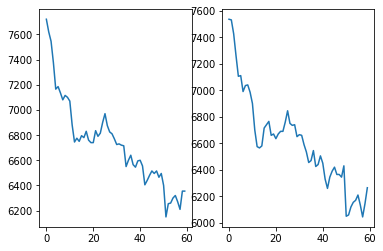

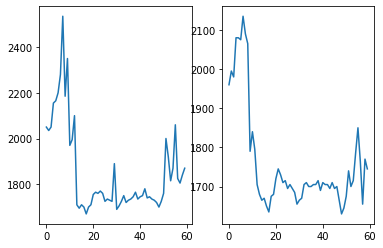

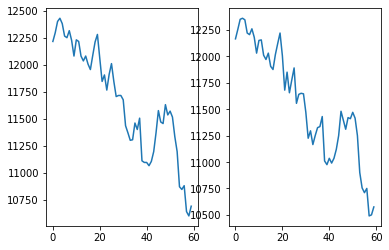

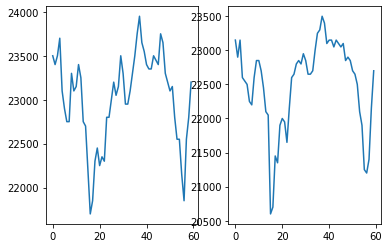

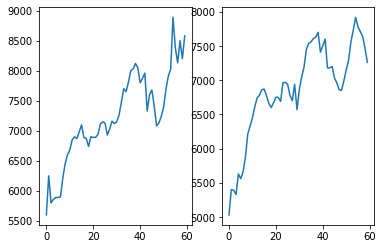

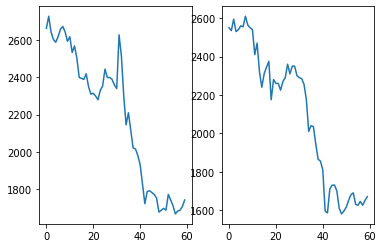

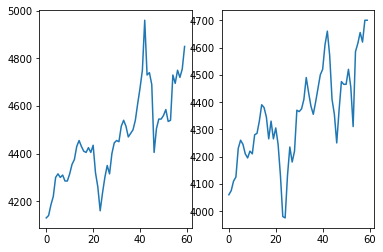

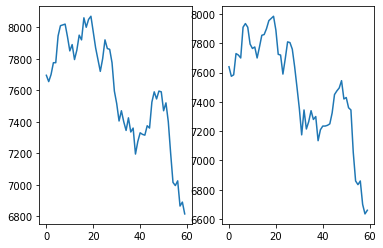

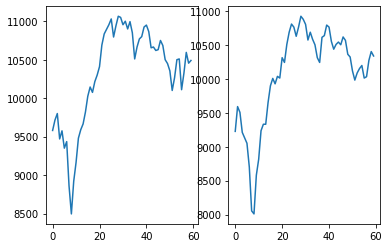

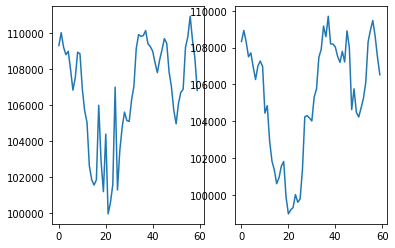

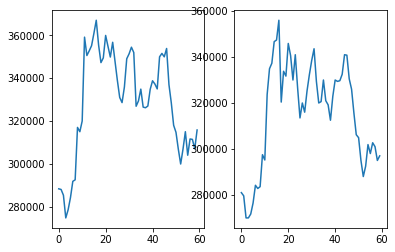

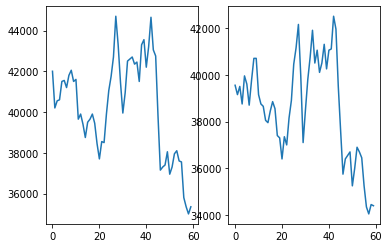

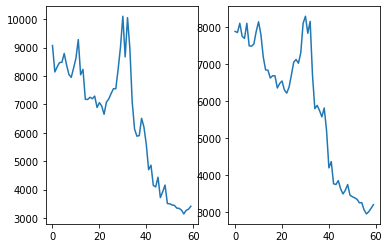

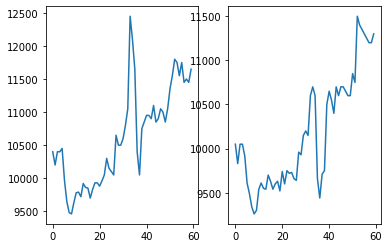

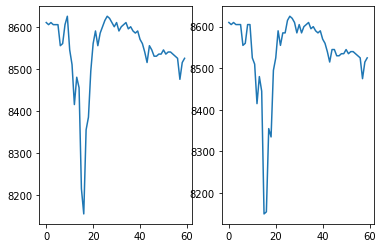

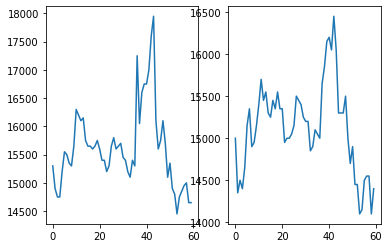

In [97]:
# unnormalized output
x = np.arange(60)
for source_raw, source_norm, target_raw,  target_norm in val_loader_60:
    source_norm, target_norm = source_norm.float().unsqueeze(1).to(device), target_norm.float().unsqueeze(1).to(device)

    _, logits = model_60(source_norm, target_norm)   # logits , shape (64, 64)
    logits = logits.softmax(dim = -1)

    _, idx = torch.max(logits, dim = -1)
    
    for i in range(16):
        s = source_raw[i]
        t = target_raw[idx[i]]
        s = s.squeeze(0).cpu()
        t = t.squeeze(0).cpu()

        plt.subplot(1, 2, 1)
        plt.plot(x, s, label = "source")
        plt.subplot(1, 2, 2)
        plt.plot(x, t, label = "target")
        plt.show()

    break


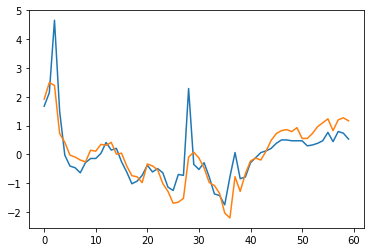

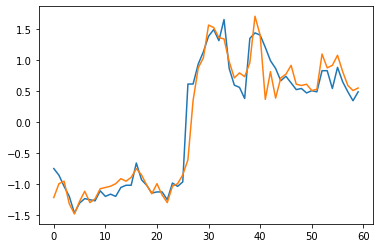

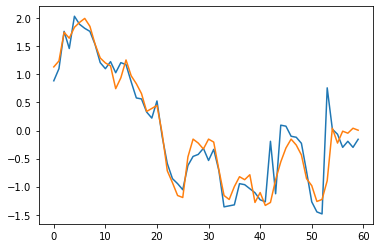

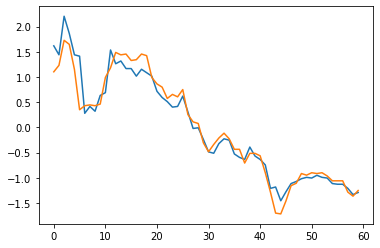

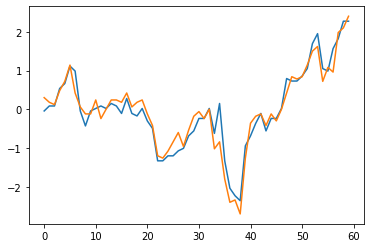

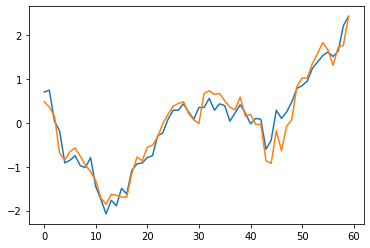

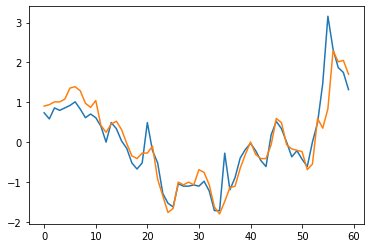

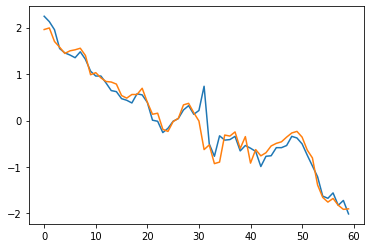

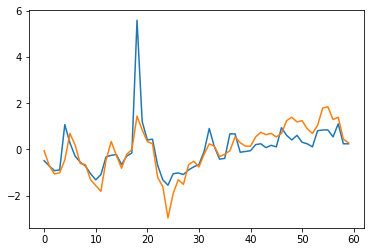

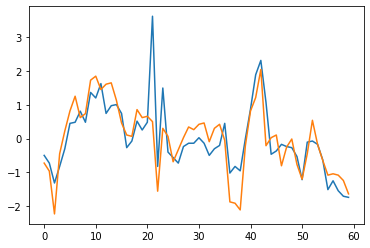

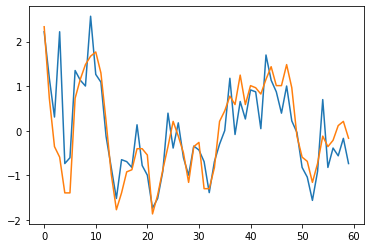

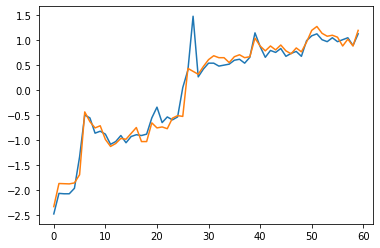

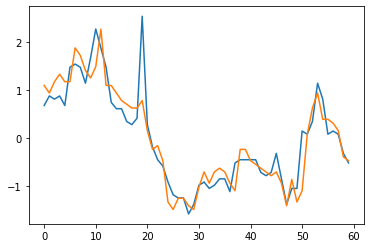

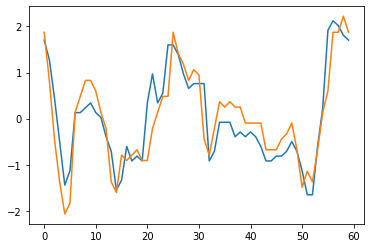

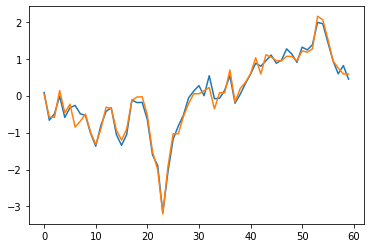

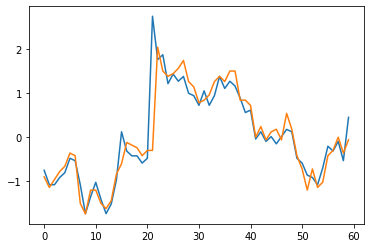

In [94]:
import matplotlib.pyplot as plt


# normalized output
x = np.arange(60)
for _, source, _,  target in val_loader_60:
    source, target = source.float().unsqueeze(1).to(device), target.float().unsqueeze(1).to(device)

    _, logits = model_60(source, target)   # logits , shape (64, 64)
    logits = logits.softmax(dim = -1)

    _, idx = torch.max(logits, dim = -1)
    
    for i in range(16):
        s = source[i]
        t = target[idx[i]]
        s = s.squeeze(0).cpu()
        t = t.squeeze(0).cpu()


        plt.plot(x, s, label = "source")
        plt.plot(x, t, label = "target")
        plt.show()

    break





In [98]:
# sequence 60짜리 데이터

#상승
inc = np.arange(60)
#횡보
stb = np.full(60,30)
#하락
dec = np.arange(60,0, -1)
# 상승 -> 하락
A = np.arange(30)
A = np.append(A, np.arange(30,0,-1))
# 하락 -> 상승
v = np.arange(30,0,-1)
v = np.append(v, np.arange(30))
# W 모양 120
w = np.arange(15,0,-1)
w = np.append(w, np.arange(0,15))
w = np.append(w,w)
# M 모양  2
m = np.arange(0,15)
m = np.append(m, np.arange(15,0,-1))
m = np.append(m,m)
# 급상승 -> 횡보 -> 급상승
f = np.arange(0,40,2)
f = np.append(f, np.arange(40,20,-1))
f = np.append(f,np.arange(20,60,2))
#급하락 -> 횡보 -> 급하락 
g = np.arange(60,20,-2)
g = np.append(g, np.arange(20,40))
g = np.append(g,np.arange(40,0,-2))
#상승 -> 약하락 -> 횡보
h = np.arange(0,40,2)
h = np.append(h,np.arange(40,20,-1))
h = np.append(h,np.full(20,20))


# 정규화

Ninc = (inc-np.mean(inc))/np.std(inc)
Nstb = (stb-np.mean(stb))/np.std(stb)
Ndec = (dec-np.mean(dec))/np.std(dec)
NA = (A-np.mean(A))/np.std(A)
Nv = (v-np.mean(v))/np.std(v)
Nw = (w-np.mean(w))/np.std(w)
Nm = (m-np.mean(m))/np.std(m)
Nf = (f-np.mean(f))/np.std(f)
Ng = (g-np.mean(g))/np.std(g)
Nh = (h-np.mean(h))/np.std(h)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


In [99]:
# tensor 형태로

inc = torch.from_numpy(inc)
stb = torch.from_numpy(stb)
dec = torch.from_numpy(dec)
A = torch.from_numpy(A)
v = torch.from_numpy(v)
w = torch.from_numpy(w)
m = torch.from_numpy(m)
f = torch.from_numpy(f)
g = torch.from_numpy(g)
h = torch.from_numpy(h)

Ninc = torch.from_numpy(Ninc).float().to(device)
Nstb = torch.from_numpy(Nstb).float().to(device)
Ndec = torch.from_numpy(Ndec).float().to(device)
NA = torch.from_numpy(NA).float().to(device)
Nv = torch.from_numpy(Nv).float().to(device)
Nw = torch.from_numpy(Nw).float().to(device)
Nm = torch.from_numpy(Nm).float().to(device)
Nf = torch.from_numpy(Nf).float().to(device)
Ng = torch.from_numpy(Ng).float().to(device)
Nh = torch.from_numpy(Nh).float().to(device)

In [357]:
print(Nm.unsqueeze(0).shape)

torch.Size([1, 60])


In [358]:
print(data_test.shape)

torch.Size([100, 60])


In [100]:
def normalization(seq):
    return (seq - seq.mean(-1, keepdims = True)) / (seq.var(-1, keepdims = True) + 1e-10) ** -0.5

def show(source, prediction, seq_length):
    x = torch.arange(seq_length)
    s = source.squeeze(0)
    p = prediction.squeeze(0)
    
    plt.subplot(1, 2, 1)
    plt.plot(x, s)
    plt.subplot(1, 2, 2)
    plt.plot(x, p)
    plt.show()

In [ ]:
print(data_test_norm)

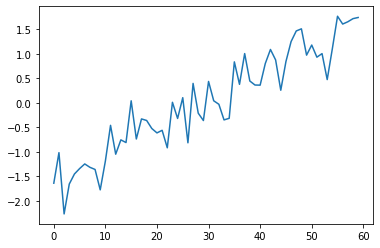

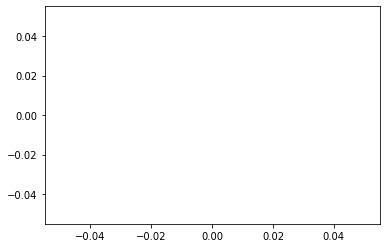

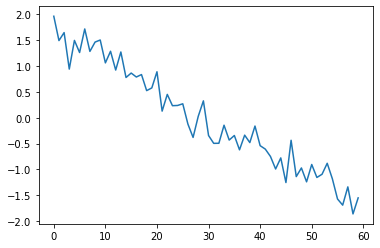

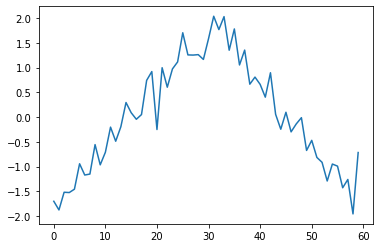

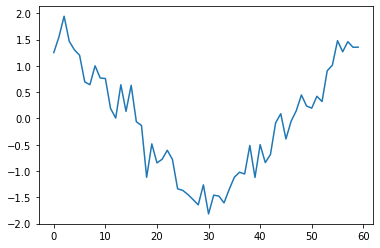

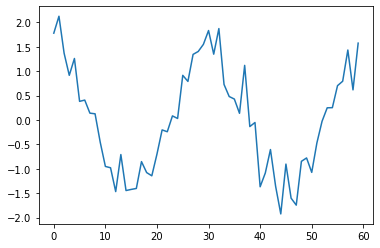

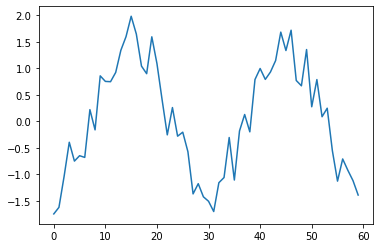

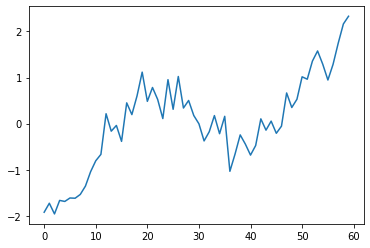

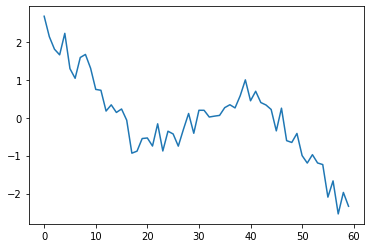

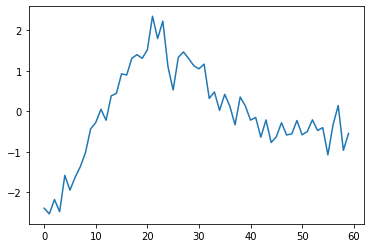

In [104]:
for t in lst:
    plt.plot((t + 0.3 *torch.randn(60).to(device)).cpu())
    plt.show()

torch.Size([1, 100])
torch.Size([1])
tensor(0, device='cuda:0')


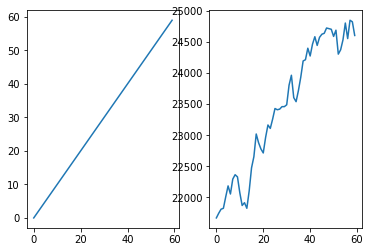

torch.Size([1, 100])
torch.Size([1])
tensor(0, device='cuda:0')


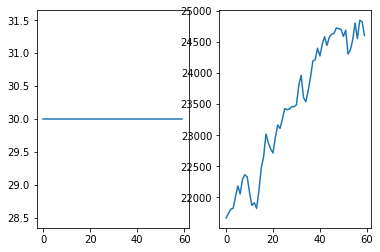

torch.Size([1, 100])
torch.Size([1])
tensor(0, device='cuda:0')


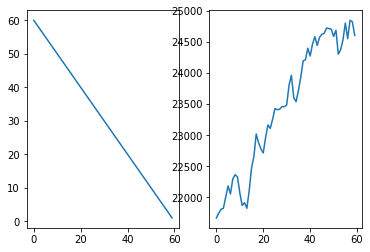

torch.Size([1, 100])
torch.Size([1])
tensor(0, device='cuda:0')


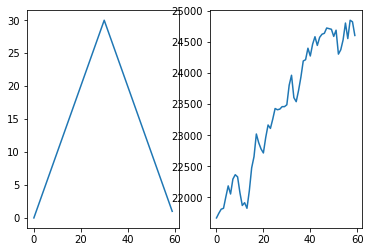

torch.Size([1, 100])
torch.Size([1])
tensor(0, device='cuda:0')


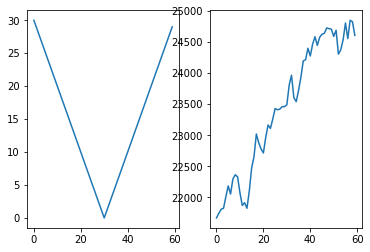

torch.Size([1, 100])
torch.Size([1])
tensor(0, device='cuda:0')


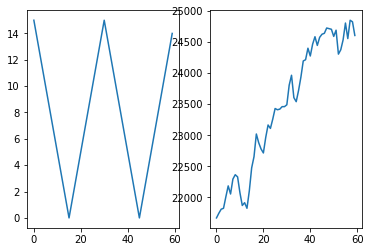

torch.Size([1, 100])
torch.Size([1])
tensor(0, device='cuda:0')


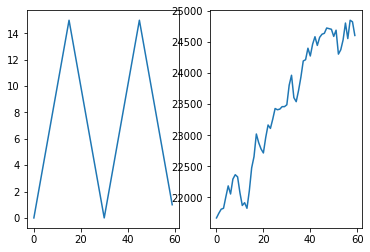

torch.Size([1, 100])
torch.Size([1])
tensor(0, device='cuda:0')


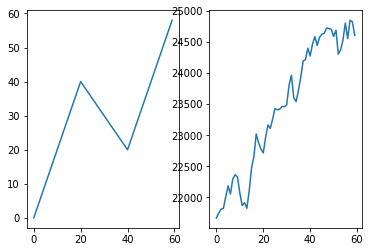

torch.Size([1, 100])
torch.Size([1])
tensor(0, device='cuda:0')


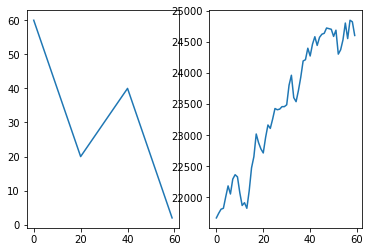

torch.Size([1, 100])
torch.Size([1])
tensor(0, device='cuda:0')


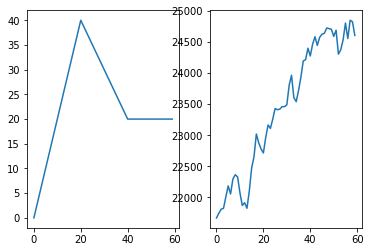

'\n# unnormalized output\nx = np.arange(60)\nfor source_raw, source_norm, target_raw,  target_norm in val_loader_60:\n    source_norm, target_norm = source_norm.float().unsqueeze(1).to(device), target_norm.float().unsqueeze(1).to(device)\n\n    _, logits = model_60(source, target_norm)   # logits , shape (64, 64)\n    logits = logits.softmax(dim = -1)\n\n    _, idx = torch.max(logits, dim = -1)\n    \n    for i in range(BATCH_SIZE):\n        s = source_raw[i]\n        t = target_raw[idx[i]]\n        s = s.squeeze(0).cpu()\n        t = t.squeeze(0).cpu()\n\n        plt.subplot(1, 2, 1)\n        plt.plot(x, s, label = "source")\n        plt.subplot(1, 2, 2)\n        plt.plot(x, t, label = "target")\n        plt.show()\n\n    break\n'

In [102]:
lst = [Ninc, Nstb, Ndec, NA, Nv, Nw, Nm, Nf, Ng, Nh]
raw_lst = [inc, stb, dec, A, v, w, m, f, g, h]

for  raw_tendency, tendency in zip(raw_lst, lst):
    _, logits = model_60((tendency + 0.5 * torch.randn(60).to(device)).unsqueeze(0).unsqueeze(0), data_test_norm.float().unsqueeze(1))
    logits = logits.softmax(dim = -1)
    print(logits.shape)

    _, idx = torch.min(logits, dim = -1)
    print(idx.shape)
    print(idx[0])
    show(raw_tendency, data_test[idx[-1]], 60)

"""
# unnormalized output
x = np.arange(60)
for source_raw, source_norm, target_raw,  target_norm in val_loader_60:
    source_norm, target_norm = source_norm.float().unsqueeze(1).to(device), target_norm.float().unsqueeze(1).to(device)

    _, logits = model_60(source, target_norm)   # logits , shape (64, 64)
    logits = logits.softmax(dim = -1)

    _, idx = torch.max(logits, dim = -1)
    
    for i in range(BATCH_SIZE):
        s = source_raw[i]
        t = target_raw[idx[i]]
        s = s.squeeze(0).cpu()
        t = t.squeeze(0).cpu()

        plt.subplot(1, 2, 1)
        plt.plot(x, s, label = "source")
        plt.subplot(1, 2, 2)
        plt.plot(x, t, label = "target")
        plt.show()

    break
"""